実験


D_Bil, I_Bilの削除→CV向上 PB低下


予測値を0, 1に(0.5以上を1)→CV低下 PB低下


Optuna→CV低下 PB低下


numboostとseed値の調整→CV向上 PB向上

# 準備

In [ ]:
# インポート
!pip install signate # signateAPI
from google.colab import drive # GoogleDrive
import pandas as pd # データフレーム
import numpy as np # 線形代数
import matplotlib.pyplot as plt # グラフ描画
import seaborn as sns # グラフ描画
import lightgbm as lgb# モデル
from sklearn.model_selection import train_test_split# 分割
from sklearn.metrics import roc_auc_score# AUCスコア
from sklearn.model_selection import StratifiedKFold# クロスバリデーション分割

In [ ]:
# Googleドライブの接続
drive.mount('/content/drive')

# signate apiの接続
!mkdir -p ~/.signate
!cp "/content/drive/MyDrive/Colab Notebooks/signateAPI/signate.json" ~/.signate/

# データリストの表示
!signate list | grep 265
# train.csv をダウンロード
!signate download -c 265

            265  【練習問題】健診データによる肝疾患判定                                            -                               947
sample_submit.csv

test.csv

train.csv


Download completed.


# データの前処理

In [ ]:
# データの読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# trainか判別するためのフラグ列
train['is_train'] = 1
test['is_train'] = 0
# 結合
combine = pd.concat([train, test])

# 表示
display(combine.head())

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,is_train
0,0,60,Male,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1.0,1
1,1,28,Female,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0.0,1
2,2,60,Male,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1.0,1
3,3,20,Male,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0.0,1
4,4,44,Female,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0.0,1


In [ ]:
# 基本統計量
combine.describe()


,id,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,is_train
count,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1269.000000,891.000000,1273.000000
mean,636.000000,43.220738,2.818225,1.202435,263.442419,66.169128,83.098036,6.523645,3.230793,1.000575,0.483726,0.699921
std,367.627756,16.559379,5.635125,2.493643,210.923492,162.487463,190.699519,1.033571,0.769624,0.303745,0.500016,0.458472
min,0.000000,3.000000,0.200000,0.100000,63.000000,9.800000,10.100000,2.600000,0.900000,0.100000,0.000000,0.000000
25%,318.000000,31.000000,0.800000,0.200000,170.900000,21.900000,23.000000,5.900000,2.700000,0.810000,0.000000,0.000000
50%,636.000000,44.000000,1.100000,0.300000,197.100000,30.100000,35.000000,6.600000,3.200000,0.990000,0.000000,1.000000
75%,954.000000,57.000000,2.000000,0.900000,278.900000,51.900000,65.100000,7.200000,3.800000,1.170000,1.000000,1.000000
max,1272.000000,90.000000,75.300000,19.800000,2110.100000,2000.200000,2946.000000,9.600000,5.600000,2.970000,1.000000,1.000000


In [ ]:
# 欠損値
#train.isnull().sum()
train[train['AG_ratio'].isnull()]
#train[train['Alb']<4]

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,is_train
31,31,75,Male,8.3,4.6,386.1,30.0,25.1,5.6,1.9,NaN,1,1
278,278,29,Male,1.3,0.3,75.0,25.0,26.0,5.2,2.8,NaN,1,1
495,495,49,Male,0.8,0.3,189.1,18.2,20.1,7.3,3.8,NaN,0,1
648,648,64,Male,0.8,0.2,199.0,19.1,22.2,6.2,3.6,NaN,0,1


In [ ]:
# 世代（Generation）列を追加
bins = list(range(0, 101, 20))  # 0〜100の範囲で20年ごと
labels = [(i + (i+20))/2 for i in range(0, 90, 20)]
combine['Generation'] = pd.cut(combine['Age'], bins=bins, labels=labels, right=False)
combine.head()

# GenderをFemaleかのフラグ列に
combine['Gender'] = (combine['Gender'] == 'Female').astype(int)

# ALT_GPT / AST_GOT列を追加
combine['AST_ALT_ratio'] = combine['AST_GOT'] / combine['ALT_GPT']

# I_Bil列を追加
combine['I_Bil'] = combine['T_Bil'] - combine['D_Bil']

# I_Bilが5未満のフラグ列
combine['I_Bil_flag'] = (combine['I_Bil'] < 5).astype(int)

# AG_ratioが2.3以上のフラグ列
combine['AG_ratio_flag'] = (combine['AG_ratio'] >= 2.3).astype(int)

# albが1以上5以下のフラグ列
combine['Alb_flag'] = combine['Alb'].between(1, 5).astype(int)

# TPが3以下のフラグ列
combine["TP_flag"] = (combine["TP"] <= 3).astype(int)

# ASTが300以下のフラグ列
combine["AST_GOT_flag"] = (combine["AST_GOT"] <= 300).astype(int)

# ALTが250以下のフラグ列
combine["ALT_GPT_flag"] = (combine["ALT_GPT"] <= 250).astype(int)

# ALPが700以下のフラグ列
combine["ALP_flag"] = (combine["ALP"] <= 700).astype(int)

# D_Billが5以下のフラグ列
combine["D_Bil_flag"] = (combine["D_Bil"] <= 5).astype(int)

# T_billが10以下のフラグ列
combine["T_Bil_flag"] = (combine["T_Bil"] <= 10).astype(int)


In [ ]:
# ALPが1000以上かつdisease==0の行を削除
combine = combine[~((combine["ALP"] >= 1000) & (combine["disease"] == 0) & (combine["is_train"] == 1))]
# 消せたか確認
display(combine[((combine["ALP"] >= 1000) & (combine["disease"] == 0) & (combine["is_train"] == 1))])

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,...,I_Bil,I_Bil_flag,AG_ratio_flag,Alb_flag,TP_flag,AST_GOT_flag,ALT_GPT_flag,ALP_flag,D_Bil_flag,T_Bil_flag


In [ ]:
# 再分割
train = combine[combine['is_train'] == 1]
test = combine[combine['is_train'] == 0]
# is_train列を削除
train = train.drop(columns=['is_train'])
test = test.drop(columns=['is_train'])

# EDA

列名の整理

In [ ]:
id =['id']# 識別子
target = ['disease']# 肝疾患の有無(目的変数)

Profile = [# 個人情報
           'Age', 'Gender',
           #'Generation'
]
Bil = [# ビリルビン値
       'T_Bil',
       #'D_Bil',
       #'I_Bil',
       #'T_Bil_flag', 'D_Bil_flag', 'I_Bil_flag',
]
ALP = [# ALP値
       'ALP',
       #'ALP_flag'
]
ALT_AST = [# ALT値とAST値
           'ALT_GPT', 'AST_GOT', 'AST_ALT_ratio',
           #'ALT_GPT_flag', 'AST_GOT_flag'
]
Alb = [# alb値
       'Alb',
       #'Alb_flag'
]
AG_ratio = [# AG値
       'AG_ratio',
       #'AG_ratio_flag'
]
TP = [# TP値
      'TP',
      #'TP_flag'
]

features = (# 特徴量
    Profile
    + Bil
    + ALP
    + ALT_AST
    + Alb
    + AG_ratio
    + TP
)

相関の確認

In [ ]:
# 列を指定
train_excluded = train[features]
# 相関行列の作成
corr_matrix = train_excluded.corr()
# ヒートマップの作成
plt.figure(figsize=(100, 98))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# フォントサイズを調整
for text in ax.texts:
    text.set_fontsize(70)  # 好きなサイズに調整

# 軸ラベルのフォントサイズを変更
ax.set_xticklabels(ax.get_xticklabels(), fontsize=30)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=30)

# タイトルや軸ラベルのフォントサイズを変更
plt.title("Heatmap_train", fontsize=70)  # タイトルのフォントサイズ
plt.xlabel("Columns", fontsize=0)  # x軸ラベルのフォントサイズ
plt.ylabel("Rows", fontsize=0)  # y軸ラベルのフォントサイズ

plt.show()

disease(目的変数)の割合の確認

<ipython-input-295-5ac88a528e27>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='viridis')


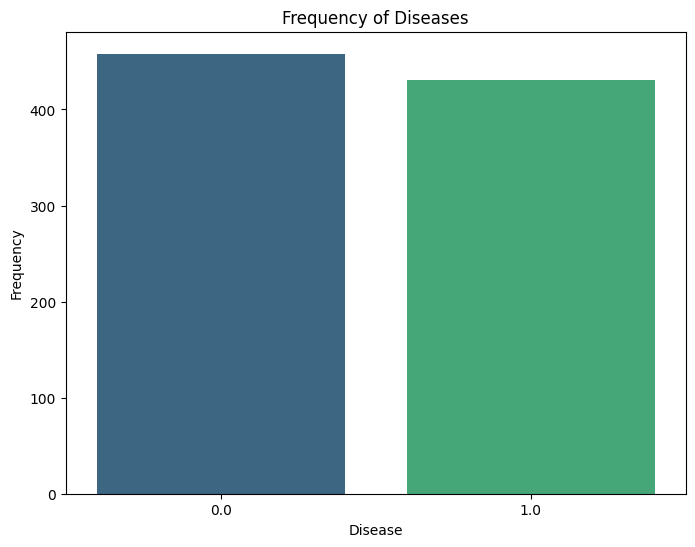

In [ ]:
# 'disease'の出現頻度をカウント
disease_counts = train['disease'].value_counts()

# ヒストグラム（棒グラフ）の作成
plt.figure(figsize=(8, 6))
sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='viridis')

# グラフのタイトルとラベル
plt.title('Frequency of Diseases')
plt.xlabel('Disease')
plt.ylabel('Frequency')

# グラフを表示
plt.show()

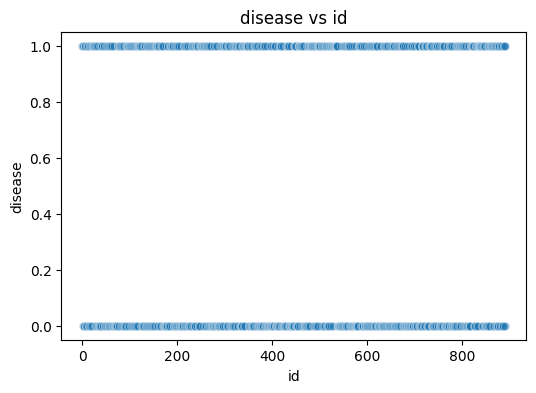

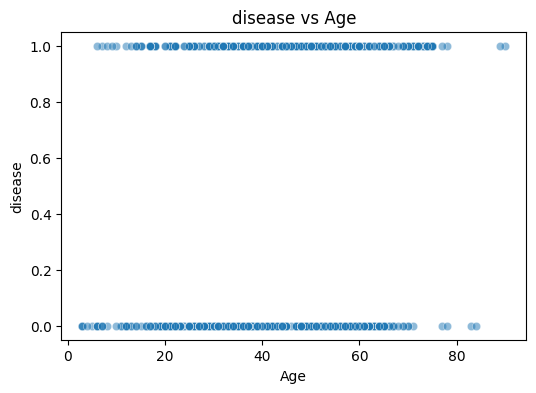

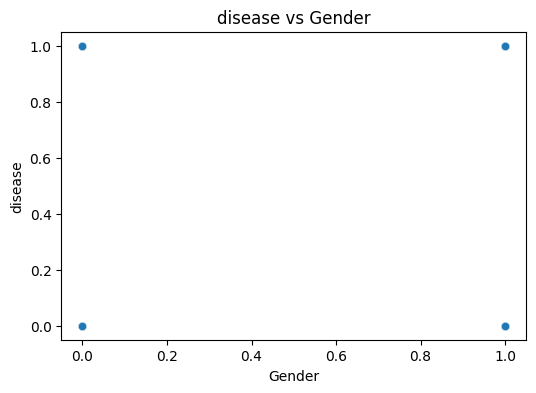

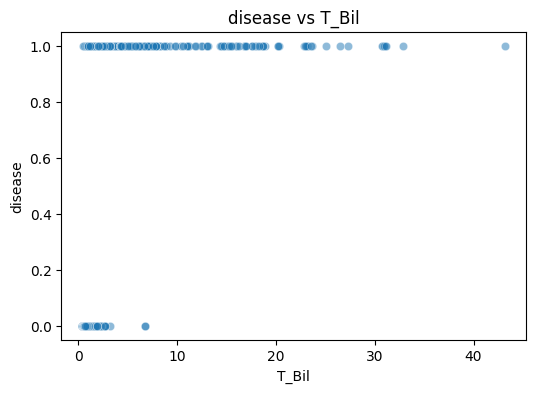

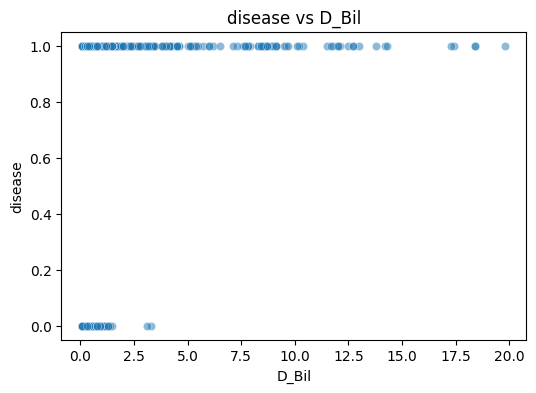

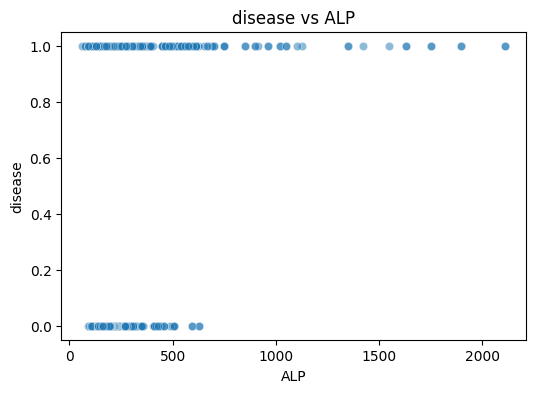

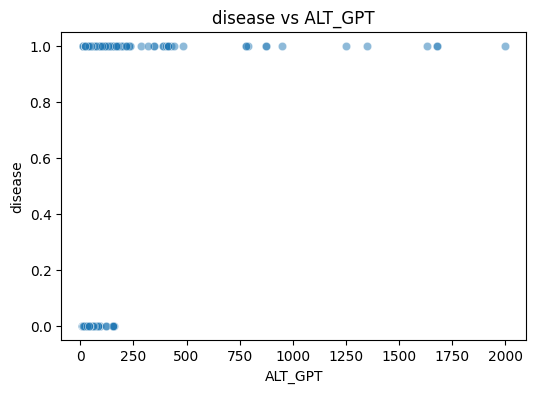

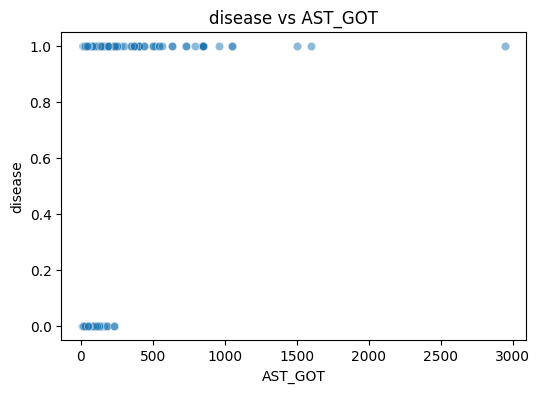

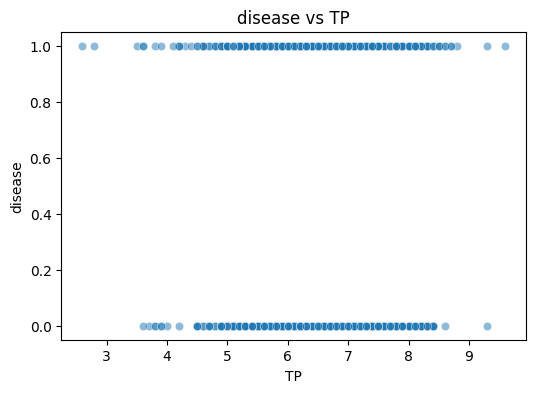

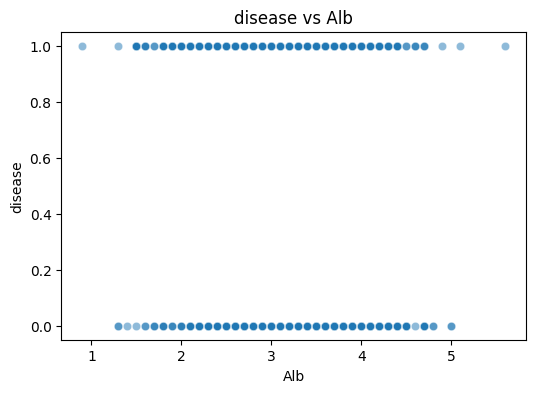

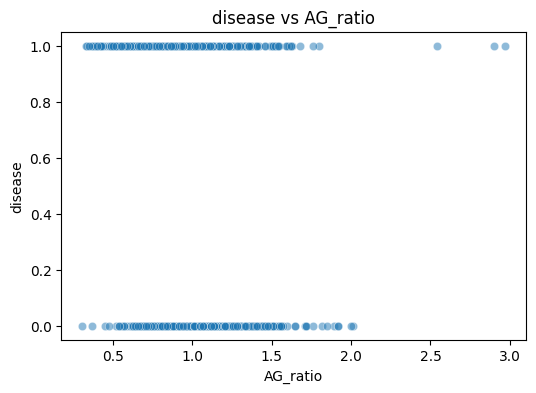

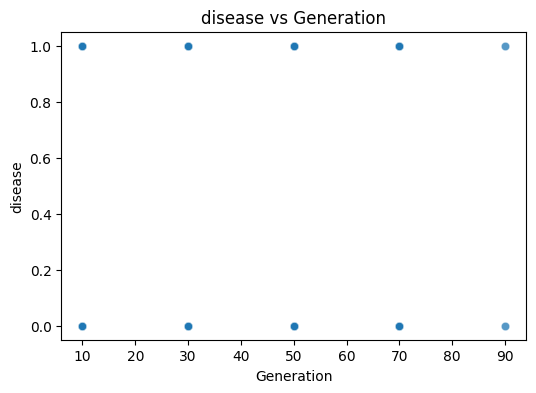

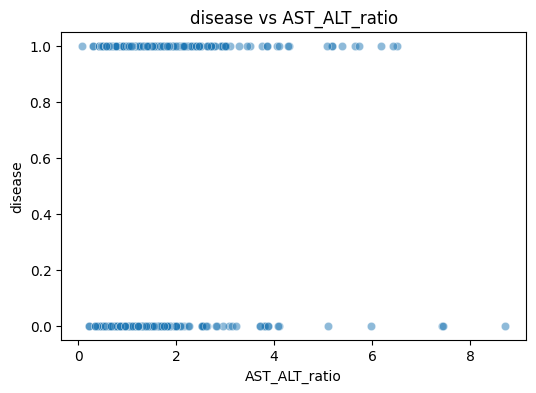

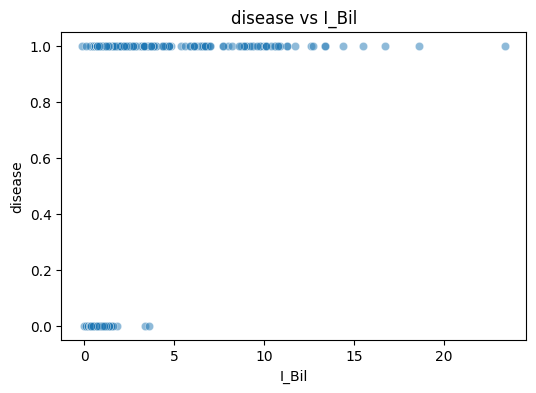

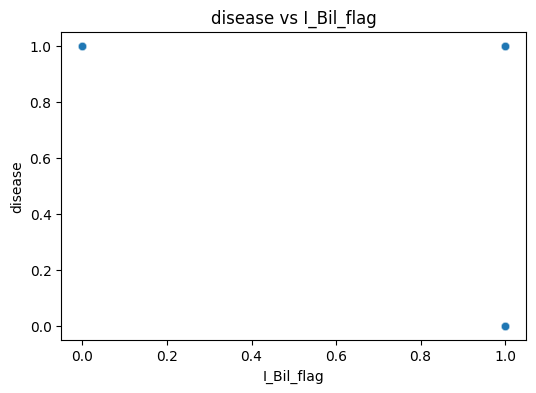

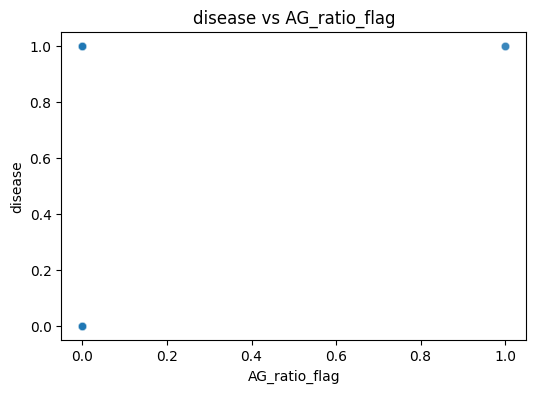

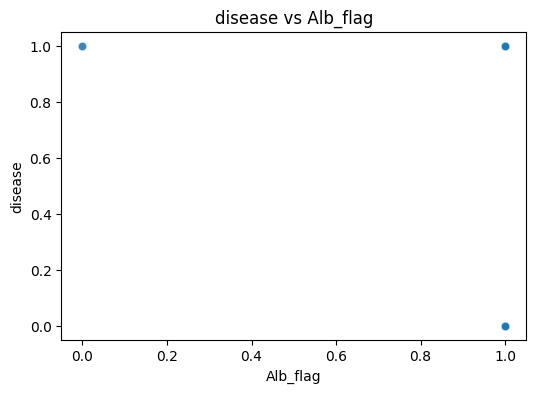

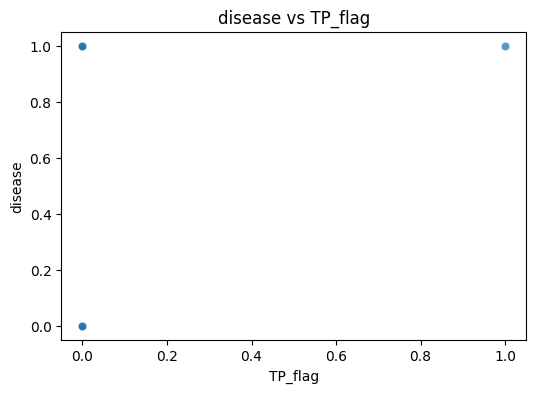

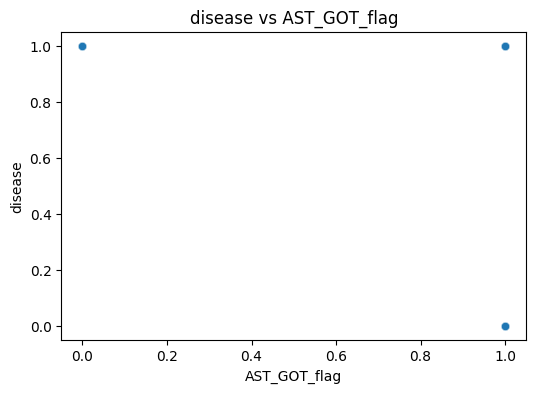

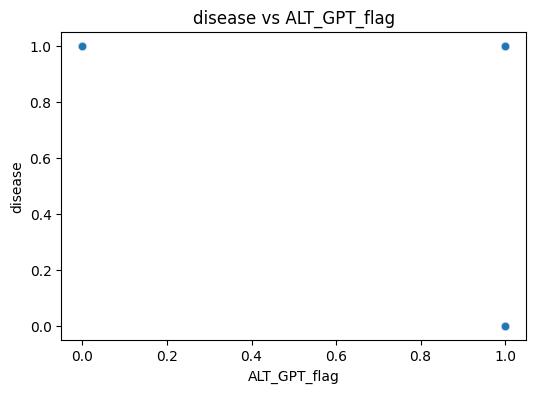

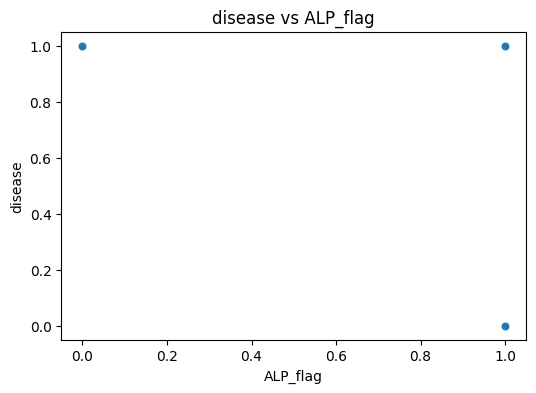

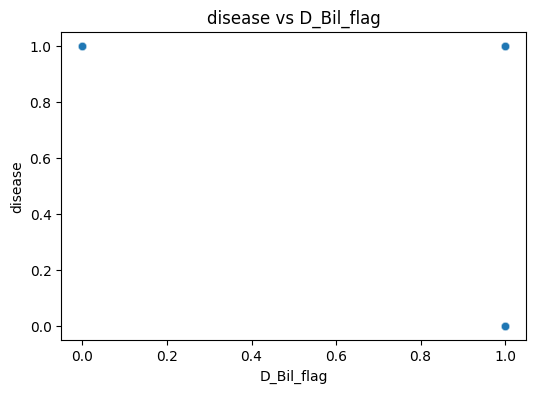

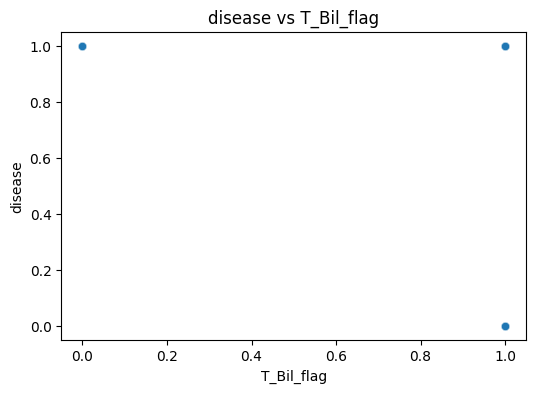

In [ ]:
# disease列以外の全ての列との散布図を個別に作成
for col in train.columns:
    if col != "disease":
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=train, x=col, y="disease", alpha=0.5)
        plt.title(f"disease vs {col}")
        plt.show()

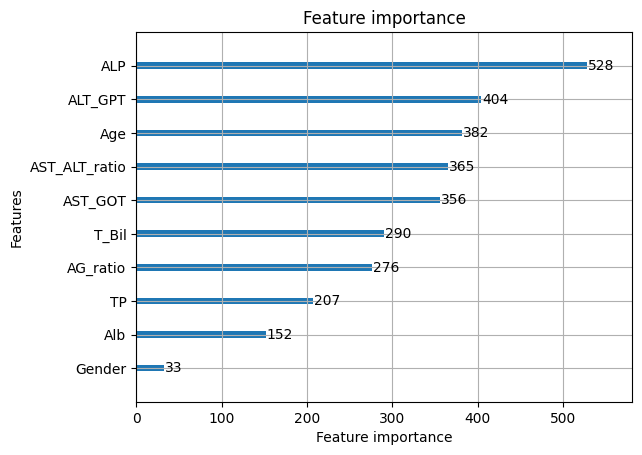

,Feature,Importance
2,T_Bil,2609.515301
3,ALP,824.725144
0,Age,592.256004
5,AST_GOT,525.863609
4,ALT_GPT,519.293959
8,AG_ratio,407.804594
6,AST_ALT_ratio,398.547757
9,TP,256.158808
7,Alb,156.938978
1,Gender,66.564639


In [ ]:
# LightGBMの重要度確認
X = train[features]  # 特徴量のデータ
y = train[target]    # ターゲット（0 or 1のフラグ）
# データセットの準備
d_train = lgb.Dataset(X, label=y)

# ハイパーパラメータ（2値分類用）
params = {
    'objective': 'binary',  # 2値分類
    'metric': 'auc',  # AUCを評価指標
    'verbosity': -1
}

# モデルの学習
model = lgb.train(params, d_train)

# 重要度の可視化
lgb.plot_importance(model)
plt.show()

# 重要度を数値データで確認
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importance(importance_type='gain')
}).sort_values(by='Importance', ascending=False)

display(importance_df)

# モデル学習

Optuna

In [314]:
!pip install optuna
import optuna

# データの準備
train_X = train[features]
train_y = train[target]

# Optunaの目的関数
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': trial.suggest_int('random_state', 1, 10000),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 1000)
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, valid_idx in kf.split(train_X, train_y):
        X_train, X_valid = train_X.iloc[train_idx], train_X.iloc[valid_idx]
        y_train, y_valid = train_y.iloc[train_idx], train_y.iloc[valid_idx]

        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

        model = lgb.train(
            params,
            train_data,
            valid_sets=[valid_data],
            valid_names=['valid'],
        )

        y_pred = model.predict(X_valid)
        auc_scores.append(roc_auc_score(y_valid, y_pred))

    return np.mean(auc_scores)

# Optunaの実行
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 最適なパラメータの出力
print('Best parameters:', study.best_params)

import optuna.visualization as vis

# 最適化の進行状況をプロット
vis.plot_optimization_history(study).show()

# 各パラメータの重要度
vis.plot_param_importances(study).show()

# 各パラメータとスコアの関係をプロット
vis.plot_slice(study).show()

[I 2025-02-05 04:20:45,310] A new study created in memory with name: no-name-c63f6b05-5bcd-401d-b8ed-bc4c00b3bc08
<ipython-input-314-fba773f281ce>:15: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-314-fba773f281ce>:19: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-314-fba773f281ce>:20: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-314-fba773f281ce>:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

KeyboardInterrupt: 

LightGBM

Fold 1


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Fold 1 AUC: 0.9869
Fold 2


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Fold 2 AUC: 0.9510
Fold 3


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Fold 3 AUC: 0.9531
Fold 4


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Fold 4 AUC: 0.9483
Fold 5


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Fold 5 AUC: 0.9534
Mean Validation AUC: 0.9585


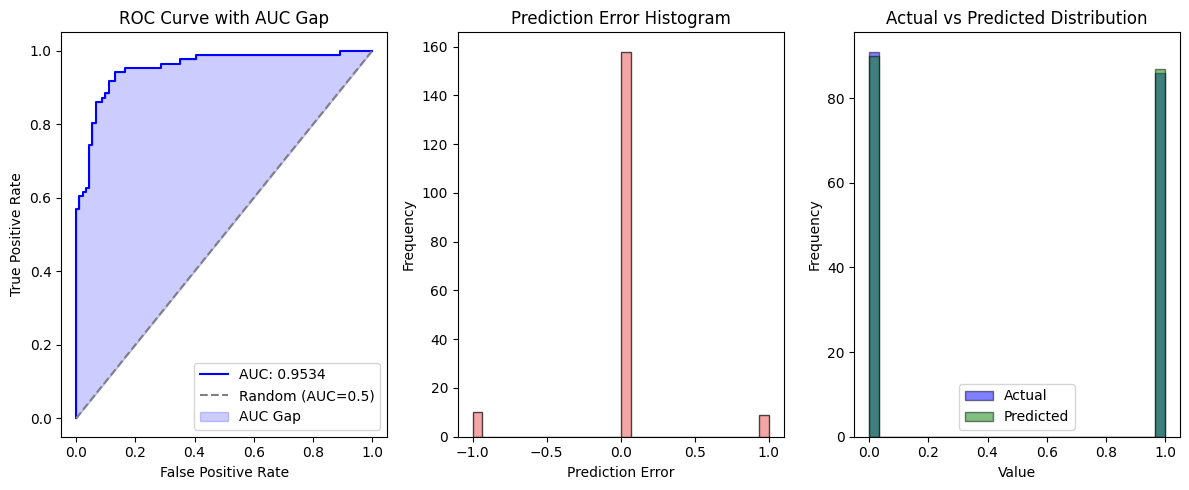

In [316]:
# LightGBM
train_X = train[features]
train_y = train[target]

# K-Fold の設定
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

# パラメータ設定

params = {
    'random_state': 2462,
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    #'random_state': 42,
    'num_boost_round': 595
}

'''
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.18528562149048614,
    'num_leaves': 136,
    'max_depth': 10,
    'min_child_samples': 46,
    'subsample': 0.9983835429085616,
    'colsample_bytree': 0.6875944776335254,
    'reg_alpha': 2.2373805027213665e-06,
    'reg_lambda': 1.98606343700105e-06,
    'random_state': 2462,
    'verbosity': -1,
    'num_boost_round': 595  # 最適なブースト回数
}
'''

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_X, train_y)):
    print(f'Fold {fold + 1}')
    X_train, X_valid = train_X.iloc[train_idx], train_X.iloc[valid_idx]
    y_train, y_valid = train_y.iloc[train_idx], train_y.iloc[valid_idx]

    # LightGBMデータセット作成
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # モデル学習
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
    )

    # 予測と評価
    y_pred = model.predict(X_valid)

    auc = roc_auc_score(y_valid, y_pred)
    auc_scores.append(auc)

    print(f'Fold {fold + 1} AUC: {auc:.4f}')

# 平均AUCスコア
mean_auc = np.mean(auc_scores)
print(f'Mean Validation AUC: {mean_auc:.4f}')


# DataFrame から Series に変換(描画の為)
y_valid = y_valid.squeeze()
# y_predの0, 1版を作成（誤差をプロットする為）
y_pred_binary = (y_pred >= 0.5).astype(int)

# 予測と評価
y_pred = model.predict(X_valid)
auc = roc_auc_score(y_valid, y_pred)
auc_scores.append(auc)

# ROC曲線の描画
fpr, tpr, _ = roc_curve(y_valid, y_pred)
plt.figure(figsize=(12, 5))

# サブプロット1: ROC曲線（理想との差を影付きで表示）
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'AUC: {auc:.4f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC=0.5)')  # ランダムな分類器

# AUCのギャップを影付きで可視化
plt.fill_between(fpr, tpr, fpr, color='blue', alpha=0.2, label="AUC Gap")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC Gap')
plt.legend()

# サブプロット2: 誤差のヒストグラム
plt.subplot(1, 3, 2)
errors = y_valid - y_pred_binary# バイナリー
plt.hist(errors, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Histogram')

# サブプロット3: 実測値 vs 予測値の分布
plt.subplot(1, 3, 3)
plt.hist(y_valid, bins=30, alpha=0.5, label='Actual', color='blue', edgecolor='black')
plt.hist(y_pred_binary, bins=30, alpha=0.5, label='Predicted', color='green', edgecolor='black')# バイナリー
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# 提出

In [317]:
test_X = test[features]
test_y = test[target]

# 予測
predictions = model.predict(test_X)
#predictions = (predictions >= 0.5).astype(int)

# 提出用データフレームの作成
submission = pd.DataFrame({'id': test['id'], 'prediction': predictions})

# CSVとして保存
submission.to_csv('submission.csv', index=False, header=False)

print("Submission file saved as 'submission.csv'")


Submission file saved as 'submission.csv'
